In [1]:
%config IPCompleter.greedy=True

In [2]:
import sys
import os
import pandas as pd
sys.path.append("../..") # relative path to module toolkit

In [3]:
#from keras.applications import ResNet50
#from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras_preprocessing.image import ImageDataGenerator
from toolkit import getLabelsFromDir, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


tf.estimator package not installed.
tf.estimator package not installed.


In [4]:
# setup
batch_size = 1
val_dir = "../../../images/images_genus/val/"
val_images = 3381
datasetDir = "images_genus/"
saved_model = 'resNet50pretrained_highest_val_acc.h5'
results_file = "results.csv"

In [5]:
labels = getLabelsFromDir(val_dir)
val_datagen = ImageDataGenerator(rescale=1./255.)
validation_steps = int(val_images/batch_size) 

In [6]:
model = load_model(saved_model)

In [7]:
val_generator = val_datagen.flow_from_directory(val_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    target_size=(224, 224),
                                                    shuffle=False,
                                                    seed=1)

Found 3381 images belonging to 44 classes.


In [8]:
Y_pred = model.predict_generator(val_generator, steps=validation_steps, verbose=1)

3381/3381 [==============================] - 87s 26ms/step


In [9]:
y_pred = np.argmax(Y_pred, axis=1)
y_pred3 = [y[-3:] for y in np.argsort(Y_pred, axis=1)] 

In [10]:
print(classification_report(val_generator.classes, y_pred, target_names=labels))

              precision    recall  f1-score   support

  Lobrathium       0.60      0.55      0.57        22
    Achenium       0.73      1.00      0.84         8
 Acylophorus       1.00      0.90      0.95        20
     Astenus       0.97      0.99      0.98       115
     Atrecus       1.00      0.93      0.96        14
     Bisnius       0.84      0.90      0.87       205
      Cafius       0.95      0.98      0.97        58
  Creophilus       0.42      0.89      0.57         9
Dinothenarus       0.80      1.00      0.89         8
        Emus       1.00      0.75      0.86         4
 Erichsonius       0.85      0.97      0.91        36
   Euryporus       1.00      0.88      0.93         8
     Gabrius       0.94      0.98      0.96       114
  Gabronthus       1.00      0.80      0.89         5
 Gauropterus       0.93      1.00      0.97        14
  Gyrohypnus       0.78      0.92      0.85        51
 Heterothops       0.96      0.87      0.92        63
  Lathrobium       0.95    

Confusion matrix, without normalization
[[12  3  0 ...,  0  0  0]
 [ 0  8  0 ...,  0  0  0]
 [ 0  0 18 ...,  0  0  0]
 ..., 
 [ 0  0  0 ..., 79  0  0]
 [ 0  0  0 ...,  0  2  0]
 [ 0  0  0 ...,  0  0 38]]


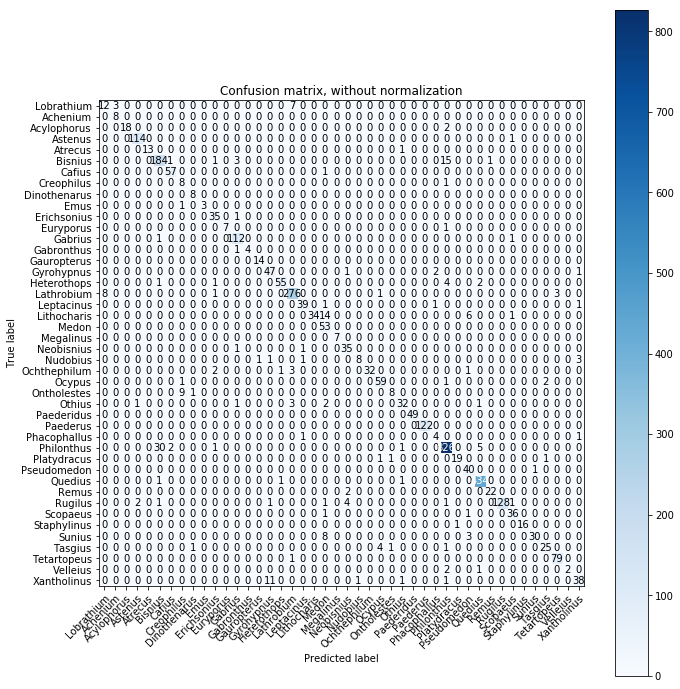

In [11]:
y_true = val_generator.classes
matplotlib.rcParams['figure.figsize'] = [10, 10]
plot_confusion_matrix(y_true, y_pred, np.array(labels))

In [12]:
labels = (val_generator.class_indices) # dict of label:index
labels = dict((i,l) for l,i in labels.items()) # dict of index:label

In [13]:
# create pd.dataframe and save predictions to .csv
filenames=[datasetDir + name for name in val_generator.filenames]
y_pred_labels = [labels[y] for y in y_pred]
y_true_labels = [labels[y] for y in y_true]
y_pred3_labels = []
for i,top3 in enumerate(y_pred3):
    l = []
    for top in top3:
        l.append((labels[top], Y_pred[i][top]))
    y_pred3_labels.append(l)

results=pd.DataFrame({"Filename":filenames,
                      "Label":y_true_labels,
                      "Prediction1":y_pred_labels,
                      "Prediction3":y_pred3_labels})
results.to_csv(results_file,index=True)